<a href="https://colab.research.google.com/github/sfnesbit/CSC466-Team13/blob/main/CSC_466_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 466 Team 13 Food Image Classification
Ty Farris | Marine Cossoul | Sean Nesbit

[Multiclass image classification article](https://towardsdatascience.com/end-to-end-pipeline-for-setting-up-multiclass-image-classification-for-data-scientists-2e051081d41c)

[Also](https://medium.com/swlh/convolutional-neural-networks-for-multiclass-image-classification-a-beginners-guide-to-6dbc09fabbd)

##  Mount drive
*You may need to visit CSC466 folder, and 'Add Shortcut to Drive' or 'Move To > My Drive"*

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
datadir = "drive/MyDrive/CSC466/csc466_data/"
testdir = datadir+'images_test/'
traindir = datadir+'images_train/'

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/CSC466/csc466_data

food_c101_n1000_r384x384x3.h5	    food_test_c101_n1000_r64x64x1.h5
food_c101_n10099_r32x32x1.h5	    food_test_c101_n1000_r64x64x3.h5
food_c101_n10099_r32x32x3.h5	    images_npy
food_c101_n10099_r64x64x1.h5	    images_test
food_c101_n10099_r64x64x3.h5	    images_train
food_test_c101_n1000_r128x128x1.h5  meta
food_test_c101_n1000_r128x128x3.h5  X.txt
food_test_c101_n1000_r32x32x1.h5    y.txt
food_test_c101_n1000_r32x32x3.h5


#  Create train and test datasets

### Create Training .npy files

In [ ]:
import os
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import cv2 as cv
from matplotlib import pyplot as plt

image_train_path = datadir+"images_train"
x_train = []
y_train = []

dirsRead = 0
totalFilesFound = 0
numClasses = 20

directories=[d for d in os.listdir(image_train_path) if os.path.isdir(image_train_path+'/'+d)]

for dir in directories:
  dirsRead += 1
  filesRead = 0
  print("directory: {} | {}".format(dirsRead, dir))
  f = IntProgress(min=0, max=1000) # instantiate the bar
  display(f) # display the bar

  if dirsRead > numClasses: #collect only n classes
    break

  dir_path = image_train_path + "/" + dir
  for file in os.listdir(dir_path):
    f.value += 1 # signal to increment the progress bar
    filesRead += 1
    #read in the image
    imagePath = image_train_path + "/" + dir + "/" + file
    image = cv.imread(imagePath)

    #resize the image to 128x128
    image = cv.resize(image, (128, 128)) 

    #add the image and corresponding label to x_train and y_train
    x_train.append(image)
    y_train.append(dir)
    totalFilesFound += 1

  #save results to a file
  x_train = np.array(x_train, dtype="float") / 255.0
  np.save(datadir+'images_npy' + f"/x_{dir}.npy", x_train)
  y_train = np.array(y_train)
  np.save(datadir+'images_npy' + f"/y_{dir}.npy", y_train)
  print(f'Writing file: {dir} | Found {filesRead} images, {len(x_train)} elements')
  #reset arrays
  filesRead = 0
  x_train = []
  y_train = []



# Load Train/Test data from saved .npy files

In [4]:
import numpy as np
import os
from ipywidgets import IntProgress
from IPython.display import display

x,y = None, None
count = 1
filecount = 0
temp = None
splitCount = 1000
numClasses = 10
f = IntProgress(min=0, max=numClasses*2) # instantiate the bar
display(f) # display the bar
xCount = 0
yCount = 0
for file in os.listdir(datadir+'images_npy/'):
  f.value += 1
  if "x_" in file and xCount < numClasses:
    xCount = xCount + 1
    temp = np.load(datadir+'images_npy/'+file)[:splitCount]
    if x is None:
      x = temp
    else:
      x = np.append(x,temp,0)
    
  elif 'y_' in file and yCount < numClasses:
    yCount = yCount + 1
    temp = np.load(datadir+'images_npy/'+file)[:splitCount]
    if y is None:
      y = temp
    else:
      y = np.append(y,temp, 0)
print(len(x),len(y))

IntProgress(value=0, max=20)

10000 10000


## Shuffle and split into train/test

In [5]:
from sklearn.utils import shuffle
x,y = shuffle(x,y)

x_train, y_train, x_test, y_test = [],[],[],[]
split = 0.8
val_split = 0.9
train_test_split_index = int(np.ceil(split*len(x)))
test_val_split_index = int(np.ceil(val_split*len(x)))


x_train = x[:train_test_split_index]
y_train = y[:train_test_split_index]
x_test  = x[train_test_split_index:test_val_split_index]
y_test  = y[train_test_split_index:test_val_split_index]
x_val   = x[test_val_split_index:]
y_val   = y[test_val_split_index:]

print(f'Train: ({len(x_train)}, {len(y_train)}) | Test: ({len(x_test)}, {len(y_test)}) | Val: ({len(x_val)}),({len(y_val)})')


Train: (8000, 8000) | Test: (1000, 1000) | Val: (1000),(1000)


In [6]:
ldict = {key: 0 for key in np.unique(y_train)}
for item in y_train:
  ldict[item] += 1

#creates a label mapping
labels = list(set(np.unique(y_train)).union(np.unique(y_test)))
labels = dict([(image_label.lower().replace(" ", "_"), index) for index, image_label in enumerate(labels)])
print(labels)

{'beef_tartare': 0, 'breakfast_burrito': 1, 'bread_pudding': 2, 'apple_pie': 3, 'beet_salad': 4, 'beignets': 5, 'beef_carpaccio': 6, 'baby_back_ribs': 7, 'bibimbap': 8, 'baklava': 9}


In [7]:
from keras.utils.np_utils import to_categorical   

#one hot encoded label values
categorical_labels = to_categorical(np.arange(len(labels)), num_classes=len(labels))
categorical_labels

y_train2 = []
y_test2 = []
y_val2 = []
for i in range(len(y_train)):
  label_index = labels[y_train[i]]
  y_train2.append(categorical_labels[label_index])
  
for i in range(len(y_test)):
  label_index = labels[y_test[i]]
  y_test2.append(categorical_labels[label_index])
  
for i in range(len(y_val)):
  label_index = labels[y_val[i]]
  y_val2.append(categorical_labels[label_index])

#ImageDataGenerator

In [ ]:
import tf.keras.preprocessing.image.ImageDataGenerator
train_data_dir = datadir + "images_train"

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs)

# Build model 

In [8]:
import tensorflow as tf
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=[128, 128, 3]))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(128, activation='relu'))
cnn.add(tf.keras.layers.Dense(len(labels), activation='softmax'))

cnn.summary()
cnn.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 128)       7

In [9]:
# finally train the cnn
history  = cnn.fit(x=x_train, y=np.array(y_train2), validation_data=(x_val, np.array(y_val2)), batch_size=32, epochs=20,  verbose=True)

Epoch 1/20
250/250 [==============================] - 43s 45ms/step - loss: 2.1446 - accuracy: 0.2155 - val_loss: 2.0201 - val_accuracy: 0.2870
Epoch 2/20
250/250 [==============================] - 11s 44ms/step - loss: 1.9221 - accuracy: 0.3133 - val_loss: 1.8757 - val_accuracy: 0.3450
Epoch 3/20
250/250 [==============================] - 11s 44ms/step - loss: 1.7766 - accuracy: 0.3692 - val_loss: 1.8021 - val_accuracy: 0.3650
Epoch 4/20
250/250 [==============================] - 11s 44ms/step - loss: 1.6377 - accuracy: 0.4281 - val_loss: 1.7474 - val_accuracy: 0.3980
Epoch 5/20
250/250 [==============================] - 11s 44ms/step - loss: 1.4871 - accuracy: 0.4793 - val_loss: 1.7322 - val_accuracy: 0.4080
Epoch 6/20
250/250 [==============================] - 11s 44ms/step - loss: 1.3292 - accuracy: 0.5353 - val_loss: 1.6872 - val_accuracy: 0.4320
Epoch 7/20
250/250 [==============================] - 11s 44ms/step - loss: 1.1294 - accuracy: 0.6024 - val_loss: 1.8609 - val_accuracy:

# Evaluate model

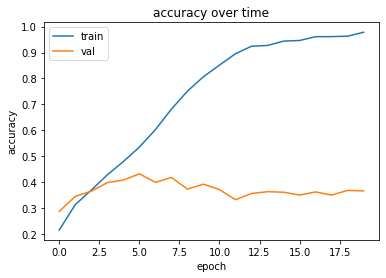

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy over time')
plt.legend(['train','val'])
plt.show()